In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.notebook import tqdm
import numpy

from io_utils import DataBaseReader
from time_series_utils import extract_time_series, train_test_split
from plots import get_lengths_plot, get_prices_plots
from arima import evaluate_with_arima, grid_search_arima

# Данные

Для начала загрузим данные. Таблицы сразу же объединим в одну через `session_id`. Колонки `date` и `time` соединим в полноценный `timestamp`.

In [3]:
reader = DataBaseReader("trade_info.sqlite3")

In [4]:
all_data = reader.get_union_data(remove_duplicates=True)
all_data.head()

,lot_size,session_id,deal_id,price,trading_type,platform_id,timestamp
0,1,35,688,-0.735466,monthly,1,2019-02-21 11:05:02
1,1,36,689,-1.129379,monthly,2,2019-02-21 11:05:02
2,17,39,647,-0.765767,monthly,1,2019-03-22 11:05:02
3,16,39,648,-0.765767,monthly,1,2019-03-22 11:05:02
4,4,39,649,-0.765767,monthly,1,2019-03-22 11:05:02


In [5]:
reader.close()

# Временные ряды

Извлечем из данных временные ряды:
- Сгруппируем данные по `session_id`
- Каждую группу преобразуем в лист из событий

In [6]:
time_series = extract_time_series(all_data)

Ряды очень разные, посмотрим как меняются длины таких последовательностей.

<AxesSubplot:ylabel='count'>

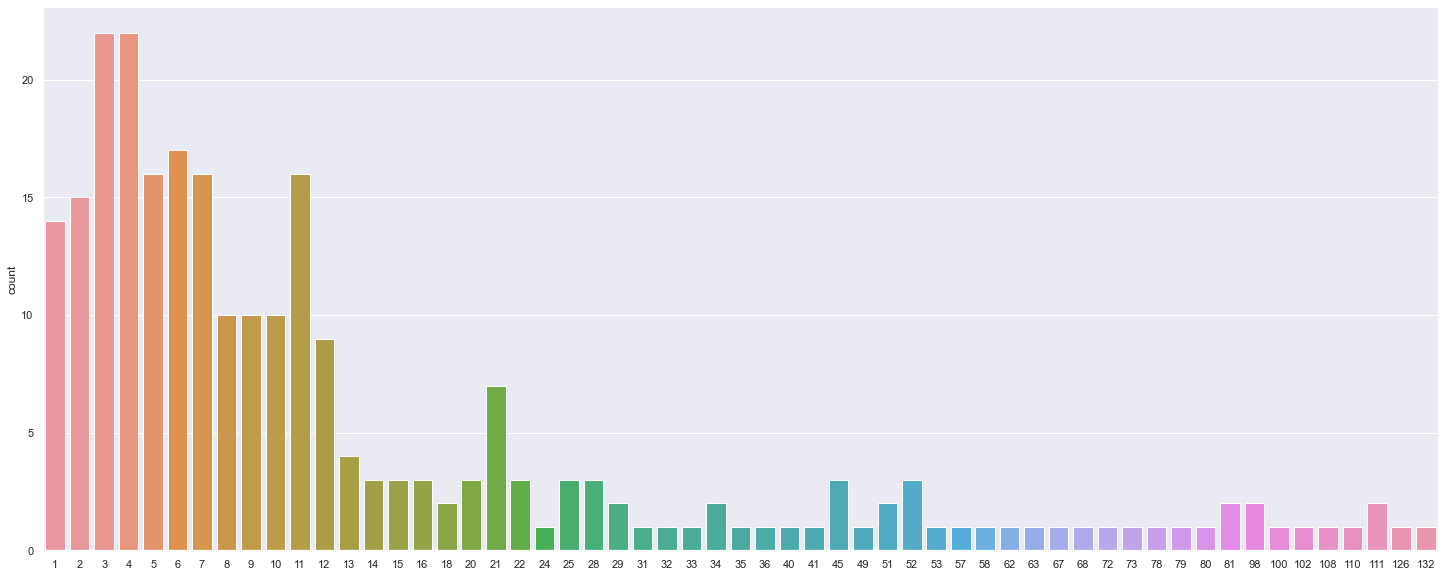

In [7]:
get_lengths_plot(time_series)

Очень много последовательностей маленькой длины. Предсказывать для них стоимости довольно сложно -- мало данных, нельзя найти закономерности. Оставим только те последовательности, которые длиннее 10 событий. Таких всё ещё много и уже можно хоть какую-то информацию извлечь.

In [8]:
time_series_long = {k: v for k, v in time_series.items() if len(v) > 10}
len(time_series_long)

104

Посмотрим на какие-то случайные графики. Интересно же, вдруг что-то и заметить получиться.

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

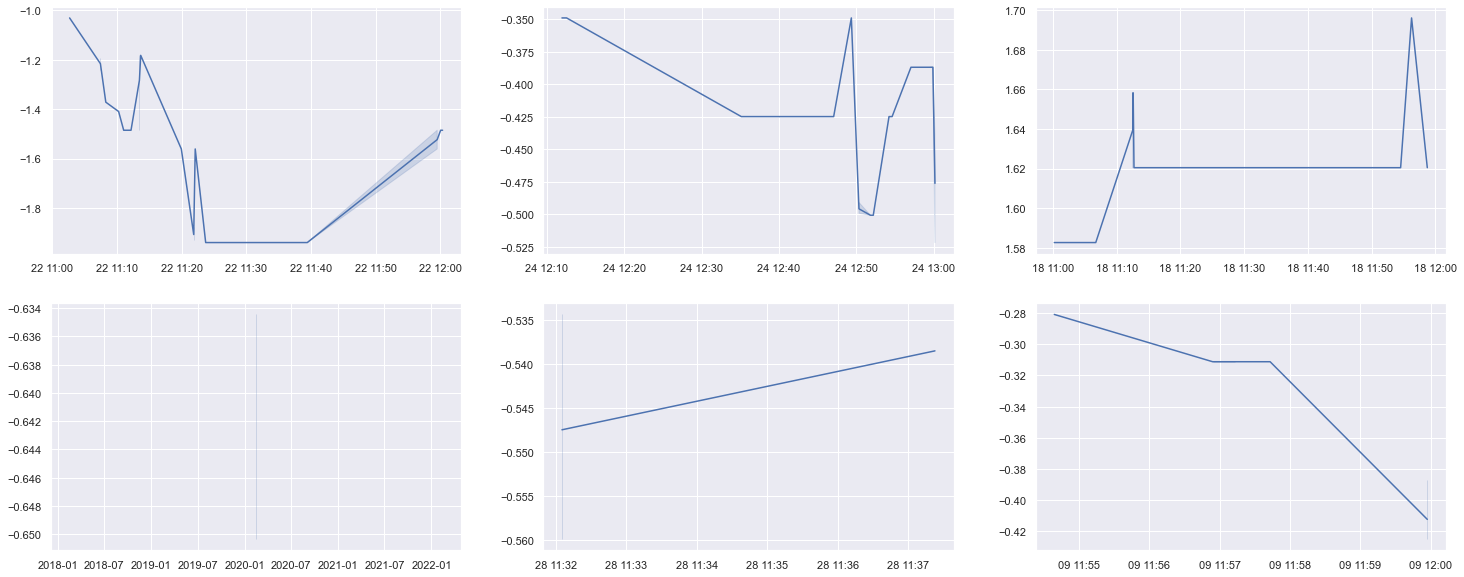

In [9]:
get_prices_plots(time_series_long, 6)

# Моделирование

Попробуем промоделировать стоимость на различных сессиях. Для начала необходимо подготовить отложенные выборки. Каждую сессию разобьем на `train` и `test`. Для этого упорядочим внутри группы по времени, а затем отрежем последние 30% под тест.

In [10]:
split_ts = {k: train_test_split(v) for k, v in time_series_long.items()}

В качестве стартовой модели воспользуемся ARIMA. В качестве метрики будет использовать косинусное расстояние:
$$
d(u; v) = 1 - \frac{u \cdot v}{||u|| \cdot ||v||}
$$
Для каждой сессии обучим отдельную модель. Общая метрика -- это среднее метрик по всем сессиям.

Подберем оптимальные параметры через поиск по сетке.

In [11]:
grid_search_arima(split_ts, 0, 5)

(0, 1, 1)

Оптимальный параметры: `(p=0, d=1, q=1)`. Посмотрим какой результат показывает модель с такими параметрами.

In [12]:
metrics = []
for train, test in tqdm(split_ts.values()):
    metrics.append(evaluate_with_arima(train, test, (0, 1, 1)))
print(f"{numpy.mean(metrics)} +/- {numpy.std(metrics)}")


0.021941865785219044 +/- 0.13480676687964582


Получили хорошую бейзлайн модель. В дальнейшем можно делать новые модели, например, с помощью бустинга, и сравнивать с этим значениями. Но кажется, что большие модели хорошо извлекают глобальные данные. Поэтому идеальный пайплайн: обучить бустинг на общем корпусе, обучить ARIMA на каждой сессии, итоговая оценка -- это блендинг двух предсказаний.